# 2021/06/28

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, UpSampling2D, Conv2DTranspose, ConvLSTM2D

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
### Pytorch code
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        print(x.shape)
        x = self.conv(x)
        print(x.shape)
        return x

torch.Size([2, 1, 10, 3])
torch.Size([2, 4, 10, 3])


In [ ]:
class double_conv(tf.keras.layers.Layer):
    def __init__(self, out_ch):
        super(double_conv, self).__init__()
        self.conv = Sequential([
            Conv2D(filters=out_ch, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            Conv2D(filters=out_ch, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU()
        ])
    
    def call(self, x):
    #   print(x.shape)
      x = self.conv(x)
    #   print(x.shape)
      return x

In [ ]:
model = double_conv(4)
x = tf.zeros([2, 3, 10, 1], tf.float32)
pred = model(x)

(2, 3, 10, 1)
(2, 3, 10, 4)


In [ ]:
### pytorch code
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class inconv(tf.keras.layers.Layer):
  def __init__(self, out_ch):
    super(inconv, self).__init__()
    self.conv = double_conv(out_ch)

  def call(self, x):
    x = self.conv(x)
    return x

model = inconv(4)
x = tf.zeros([2, 3, 10, 1], tf.float32)
pred = model(x)

In [ ]:
### pytorch code
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

In [ ]:
class down(tf.keras.layers.Layer):
    def __init__(self, out_ch):
        super(down, self).__init__()
        self.mpconv = Sequential([
            MaxPool2D(pool_size=2),
            double_conv(out_ch)
        ])

    def call(self, x):
        # print(x.shape)
        x = self.mpconv(x)
        # print(x.shape)
        return x

model = down(4)
x = tf.zeros([2, 4, 10, 1], tf.float32)
pred = model(x)

In [ ]:
### pytorch code
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        print(x1.shape)
        x1 = self.up(x1)
        print(x1.shape)
        ### encoder의 feature map과 decoder의 feature map을 모두 사용하기 위해 둘의 shape를 맞춰주는 코드
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        print(diffX, diffY)
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        ###
        x = torch.cat([x2, x1], dim=1)
        print("x:", x.shape)
        x = self.conv(x)
        print("x:", x.shape)
        return x

In [ ]:
x = torch.zeros(1, 1, 10, 3, dtype=torch.float)
y = torch.zeros(1, 1, 20, 6, dtype=torch.float)
model = up(2, 1, bilinear=False)
pred = model(x, y)

torch.Size([1, 1, 10, 3])
torch.Size([1, 1, 20, 6])
0 0
x: torch.Size([1, 2, 20, 6])
x: torch.Size([1, 1, 20, 6])


### up 클래스 변환
- 아래의 call 메서드를 보면, 패딩을 주는 부분이 있는데 TF와 Pytorch의 패딩 옵션을 주는 방법이 약간 다르다.  
- Pytorch의 경우 아래와 같이 패딩을 줄 위치를 입력한다.  
Pytorch: 
```
x2 = F.pad(x2, (diffX // 2, int(diffX / 2), diffY // 2, int(diffY / 2)))
```
- TF의 경우 아래와 같이 옵션을 입력한다.
- 자세히 보면, 리스트의 인덱스에 해당하는 차원의 윗부분에는 두번째 차원 리스트의 첫번째 element만큼의 줄에 해당하는 패딩을, 아랫부분에는 두번째 element만큼의 줄에 해당하는 패딩을 추가한다.
- 예를 들어 리스트의 0번째 element인 [0, 0]은 0번째 차원에 위 아래로 패딩을 0줄, 즉, 패딩을 주지 않겠다는 것을 의미하고, 리스트의 첫번째 element인 [diffX // 2, int(diffX / 2)]는 첫번째 차원의 윗부분은 diffX // 2 줄의 패딩을, 아래부분은 int(diffX / 2) 줄의 패딩을 추가한다는 것을 의미한다.  
Tensorflow: 
 ```
 paddings = [[0, 0],
             [diffX // 2, int(diffX / 2)],
             [diffY // 2, int(diffY / 2)],
             [0, 0]]
 x_enc = tf.pad(x_enc, paddings=paddings)
 ```

In [ ]:
class up(tf.keras.layers.Layer):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = UpSampling2D(size=(2, 2))
        else:
            self.up = Conv2DTranspose(filters=in_ch//2, kernel_size=2, strides=2)

        self.conv = double_conv(out_ch)
    
    def call(self, x_dec, x_enc):
        x_dec = self.up(x_dec)
        print(x_dec.shape)
        diffX = x_dec.shape[1] - x_enc.shape[1]
        diffY = x_dec.shape[2] - x_enc.shape[2]
        print(diffX, diffY)
        paddings = [[0, 0],
                    [diffX // 2, int(diffX / 2)],
                    [diffY // 2, int(diffY / 2)],
                    [0, 0]]
        x_enc = tf.pad(x_enc, paddings=paddings)
        print(x_enc.shape, x_enc.dtype, x_dec.dtype)
        x = tf.concat([x_enc, x_dec], axis=-1)
        print(x_enc.shape, x_dec.shape)
        print(x.shape)
        x = self.conv(x)
        print(x.shape)
        return x

In [ ]:
model = up(2, 2)
x = tf.zeros([2, 3, 10, 3], tf.float32)
y = tf.zeros([2, 4, 16, 3], tf.float32)
pred = model(x, y)

(2, 6, 20, 3)
2 4
(2, 6, 20, 3) <dtype: 'float32'> <dtype: 'float32'>
(2, 6, 20, 3) (2, 6, 20, 3)
(2, 6, 20, 6)
(2, 6, 20, 2)


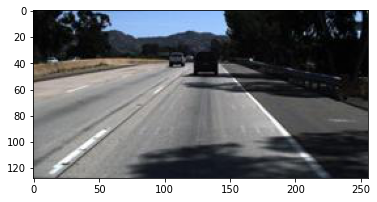

(1, 128, 256, 3)


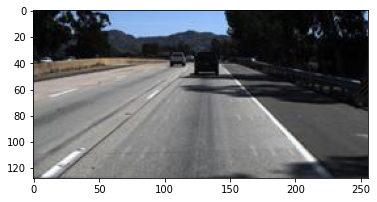

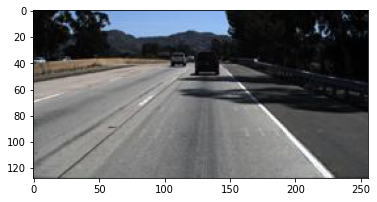

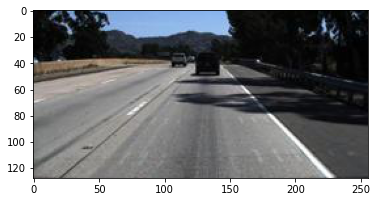

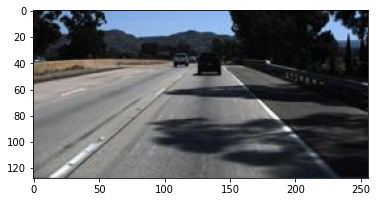

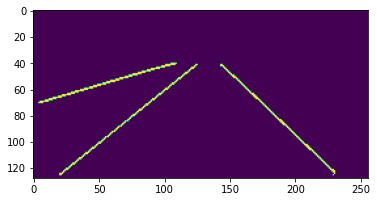

(1, 5, 128, 256, 3)
(1, 128, 256, 1)
(1, 5, 128, 256, 3) (1, 128, 256, 1) <dtype: 'float32'> <dtype: 'float32'>


In [ ]:
test_image_dir = "/content/drive/MyDrive/2_master/1_Github/Lane_detection/LaneDetectionCode/data/testset/image/1_"
test_label_dir = "/content/drive/MyDrive/2_master/1_Github/Lane_detection/LaneDetectionCode/data/testset/truth/1_13.jpg"

label = Image.open(test_label_dir)

ndata = []
for i in range(1, 6):
    data = Image.open(test_image_dir + str(3 * i - 2) + ".jpg")
    data = np.array(data)
    plt.imshow(data)
    plt.show()
    data = data.astype(np.float32)
    data = data[np.newaxis, ...]
    if i == 1:
        print(data.shape)
    ndata.append(data)

ndata = tf.concat(ndata, axis=0)
ndata = tf.expand_dims(ndata, axis=0)
nlabel = np.array(label, dtype=np.float32)
plt.imshow(nlabel)
plt.show()
nlabel = nlabel[np.newaxis, ..., np.newaxis]
print(ndata.shape)
print(nlabel.shape)

test_ds = tf.data.Dataset.from_tensor_slices((ndata, nlabel))
test_ds = test_ds.batch(64)

### up class test
for img, label in test_ds:
    print(img.shape, label.shape, img.dtype, label.dtype)
    # pred = model(img, img)
    # print(pred.shape)

In [ ]:
### Pytorch dataset generation code
from torchvision import transforms

data = []
transforms = transforms.Compose([transforms.ToTensor()])
for i in range(1, 6):
    img = Image.open(test_image_dir + str(3 * i - 2) + ".jpg")
    
    img = torch.unsqueeze(transforms(img), dim=0)
    print(img.shape)
    data.append(img)
data = torch.cat(data, 0)
print(data.shape)
label = Image.open(test_label_dir)
label = torch.squeeze(transforms(label))
print(label.shape)
sample = {'data': data, 'label': label}
# return sample

torch.Size([1, 3, 128, 256])
torch.Size([1, 3, 128, 256])
torch.Size([1, 3, 128, 256])
torch.Size([1, 3, 128, 256])
torch.Size([1, 3, 128, 256])
torch.Size([5, 3, 128, 256])
torch.Size([128, 256])


### outconv 클래스 변환

In [ ]:
### Pytorch code
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
### TF code
class outconv(tf.keras.layers.Layer):
    def __init__(self, out_ch):
        super(outconv, self).__init__()
        self.conv = Conv2D(filters=out_ch, kernel_size=1)

    def call(self, x):
        print("Shape before conv:", x.shape)
        x = self.conv(x)
        print("Shape after  conv:", x.shape)
        return x

In [ ]:
outconvModel = outconv(2)

### outconv class test
for img, label in test_ds:
    print(img.shape, label.shape)
    pred = outconvModel(img)
    print("Pred shape:", pred.shape)

(1, 128, 256, 3) (1, 128, 256)
Shape before conv: (1, 128, 256, 3)
Shape after  conv: (1, 128, 256, 2)
Pred shape: (1, 128, 256, 2)


### ConvLSTM2D 클래스 생성

In [ ]:
class ConvLSTM(tf.keras.layers.Layer):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()
        self.convlstm = ConvLSTM2D(filters)


In [ ]:
steps = 5
height = 256
width = 128
input_channels = 3
output_channels = 6

inputs = tf.keras.Input(shape=(steps, height, width, input_channels))
print(inputs.shape)
layer = tf.keras.layers.ConvLSTM2D(filters=output_channels, kernel_size=3, units=3)
# for img, label in test_ds:
#     print(img.shape, label.shape,type(img), type(label))
#     # pred = outconvModel(img)

#     pred = layer(img)
#     print("Pred shape:", pred.shape)
outputs = layer(inputs)
print(outputs.shape)

(None, 5, 256, 128, 3)


TypeError: ignored

In [2]:
## TF ConvLSTMCell
class ConvLSTMCell(tf.keras.layers.Layer):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """
        
        super(ConvLSTMCell, self).__init__()
        
        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        ### 여기서 패딩은 어떻게 처리하였는지?
        self.conv = Conv2D(filters=4*self.hidden_dim, kernel_size=self.kernel_size, padding="same", use_bias=self.bias, data_format="channels_first")

    def call(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        print(f"input_tensor.shape: {input_tensor.shape} h_cur.shape: {h_cur.shape}")
        combined = tf.concat([input_tensor, h_cur], axis=1) ## concatenate along channel axis
        print(f"combined.shape: {combined.shape}")
        combined_conv = self.conv(combined)
        print(f"combined_conv.shape: {combined_conv.shape} hidden_dim: {self.hidden_dim}")
        cc_i, cc_f, cc_o, cc_g = tf.split(value=combined_conv, num_or_size_splits=int(combined_conv.shape[1] // self.hidden_dim), axis=1)
        print(f"cc_i.shape: {cc_i.shape}")
        i = tf.sigmoid(cc_i)
        f = tf.sigmoid(cc_f)
        o = tf.sigmoid(cc_o)
        g = tf.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * tf.tanh(c_next)
        # print(h_next.shape, c_next.shape)
        return h_next, c_next
    
    def init_hidden(self, batch_size):
        return (tf.zeros([batch_size, self.hidden_dim, self.height, self.width], dtype=tf.float32),
                tf.zeros([batch_size, self.hidden_dim, self.height, self.width], dtype=tf.float32))

## TF ConvSLTM class
class ConvLSTM(tf.keras.layers.Layer):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        ## Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        print(f"kernel_size: {kernel_size}, hidden_dim: {hidden_dim}")
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError("Inconsistent list length.")
        
        self.height, self.width = input_size

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        self.cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            self.cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                               input_dim=cur_input_dim,
                                               hidden_dim=self.hidden_dim[i],
                                               kernel_size=self.kernel_size[i],
                                               bias=self.bias))

    def call(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            ## (timesteps, batch_size, channels, height, width) -> (batch_size, timesteps, channels, height, width)
            input_tensor = tf.transpose(input_tensor, perm=[1, 0, 2, 3, 4])
        
        ## Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.shape[0])
        
        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.shape[1]
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]            
            output_inner = []
            print(f"Layer {layer_idx + 1} starts.") 
            for t in range(seq_len):
                print()
                print(f"Seqeunce {t + 1} starts.")
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                print(f"h.shape: {h.shape} c.shape: {c.shape}")
                output_inner.append(h)
            
            layer_output = tf.stack(output_inner, axis=1)
            cur_layer_input = layer_output

            layer_output = tf.transpose(layer_output, perm=[1, 0, 2, 3, 4])
            print(f"layer_output.shape: {layer_output.shape}")
            print()
            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]
        
        return layer_output_list, last_state_list
    
    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
            for j in range(2):
                print(f"init_state[{i}].shape: {init_states[i][j].shape}")
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(_kernel_size):
        if not (isinstance(_kernel_size, tuple) or (isinstance(_kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')
    
    @staticmethod
    def _extend_for_multilayer(param, _num_layers):
        if not isinstance(param, list):
            param = [param] * _num_layers
        return param

In [3]:
# (self, input_size, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
tf.random.set_seed(5)
x = tf.random.normal([64, 5, 512, 8, 16], dtype=tf.float32)
# print(x.shape[0])
convlstm = ConvLSTM(input_size=(8, 16), input_dim=512, hidden_dim=[512, 512], kernel_size=(3, 3), num_layers=2, batch_first=True, bias=True)
layer_pred, state_pred = convlstm(x)
print(f"layer_output_list: {len(layer_pred)} last_state_list: {len(state_pred)}")
for i, pred in enumerate(layer_pred):
    print(f"layer_pred[{i}].shape: {pred.shape}")
print(layer_pred[0][-1, :, :, :, :].shape)

kernel_size: [(3, 3), (3, 3)], hidden_dim: [512, 512]
init_state[0].shape: (64, 512, 8, 16)
init_state[0].shape: (64, 512, 8, 16)
init_state[1].shape: (64, 512, 8, 16)
init_state[1].shape: (64, 512, 8, 16)
Layer 1 starts.

Seqeunce 1 starts.
input_tensor.shape: (64, 512, 8, 16) h_cur.shape: (64, 512, 8, 16)
combined.shape: (64, 1024, 8, 16)
combined_conv.shape: (64, 2048, 8, 16) hidden_dim: 512
cc_i.shape: (64, 512, 8, 16)
h.shape: (64, 512, 8, 16) c.shape: (64, 512, 8, 16)

Seqeunce 2 starts.
input_tensor.shape: (64, 512, 8, 16) h_cur.shape: (64, 512, 8, 16)
combined.shape: (64, 1024, 8, 16)
combined_conv.shape: (64, 2048, 8, 16) hidden_dim: 512
cc_i.shape: (64, 512, 8, 16)
h.shape: (64, 512, 8, 16) c.shape: (64, 512, 8, 16)

Seqeunce 3 starts.
input_tensor.shape: (64, 512, 8, 16) h_cur.shape: (64, 512, 8, 16)
combined.shape: (64, 1024, 8, 16)
combined_conv.shape: (64, 2048, 8, 16) hidden_dim: 512
cc_i.shape: (64, 512, 8, 16)
h.shape: (64, 512, 8, 16) c.shape: (64, 512, 8, 16)

Seqeun

In [ ]:
for img, label in test_ds:
    # print(img.shape)
    # print(tf.transpose(img, perm=[1, 0, 2, 3, 4]).shape)
    print(img[:, 1, :, :, :].shape)

(1, 128, 256, 3)


In [ ]:
x = tf.random.normal([64, 2048, 8, 16], dtype=tf.float32)
print(x.shape)
size = 512
# print(type(int(x.shape[1] // size)))
x1, x2, x3, x4 = tf.split(value=x, num_or_size_splits=int(x.shape[1] // size), axis=1)
print(x1.shape)

(64, 2048, 8, 16)
(64, 512, 8, 16)
